# Final Project - Credit default prediction 
## Goal: Predict whether a loan applicant is likely to default or not
## Type: Binary classification
## Value: helps financial institution make better lending decisions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix


In [3]:
# Read test and training data from csv file
credit_data = pd.read_csv('credit.csv')

In [4]:
credit_data.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes


# Data preprocessor

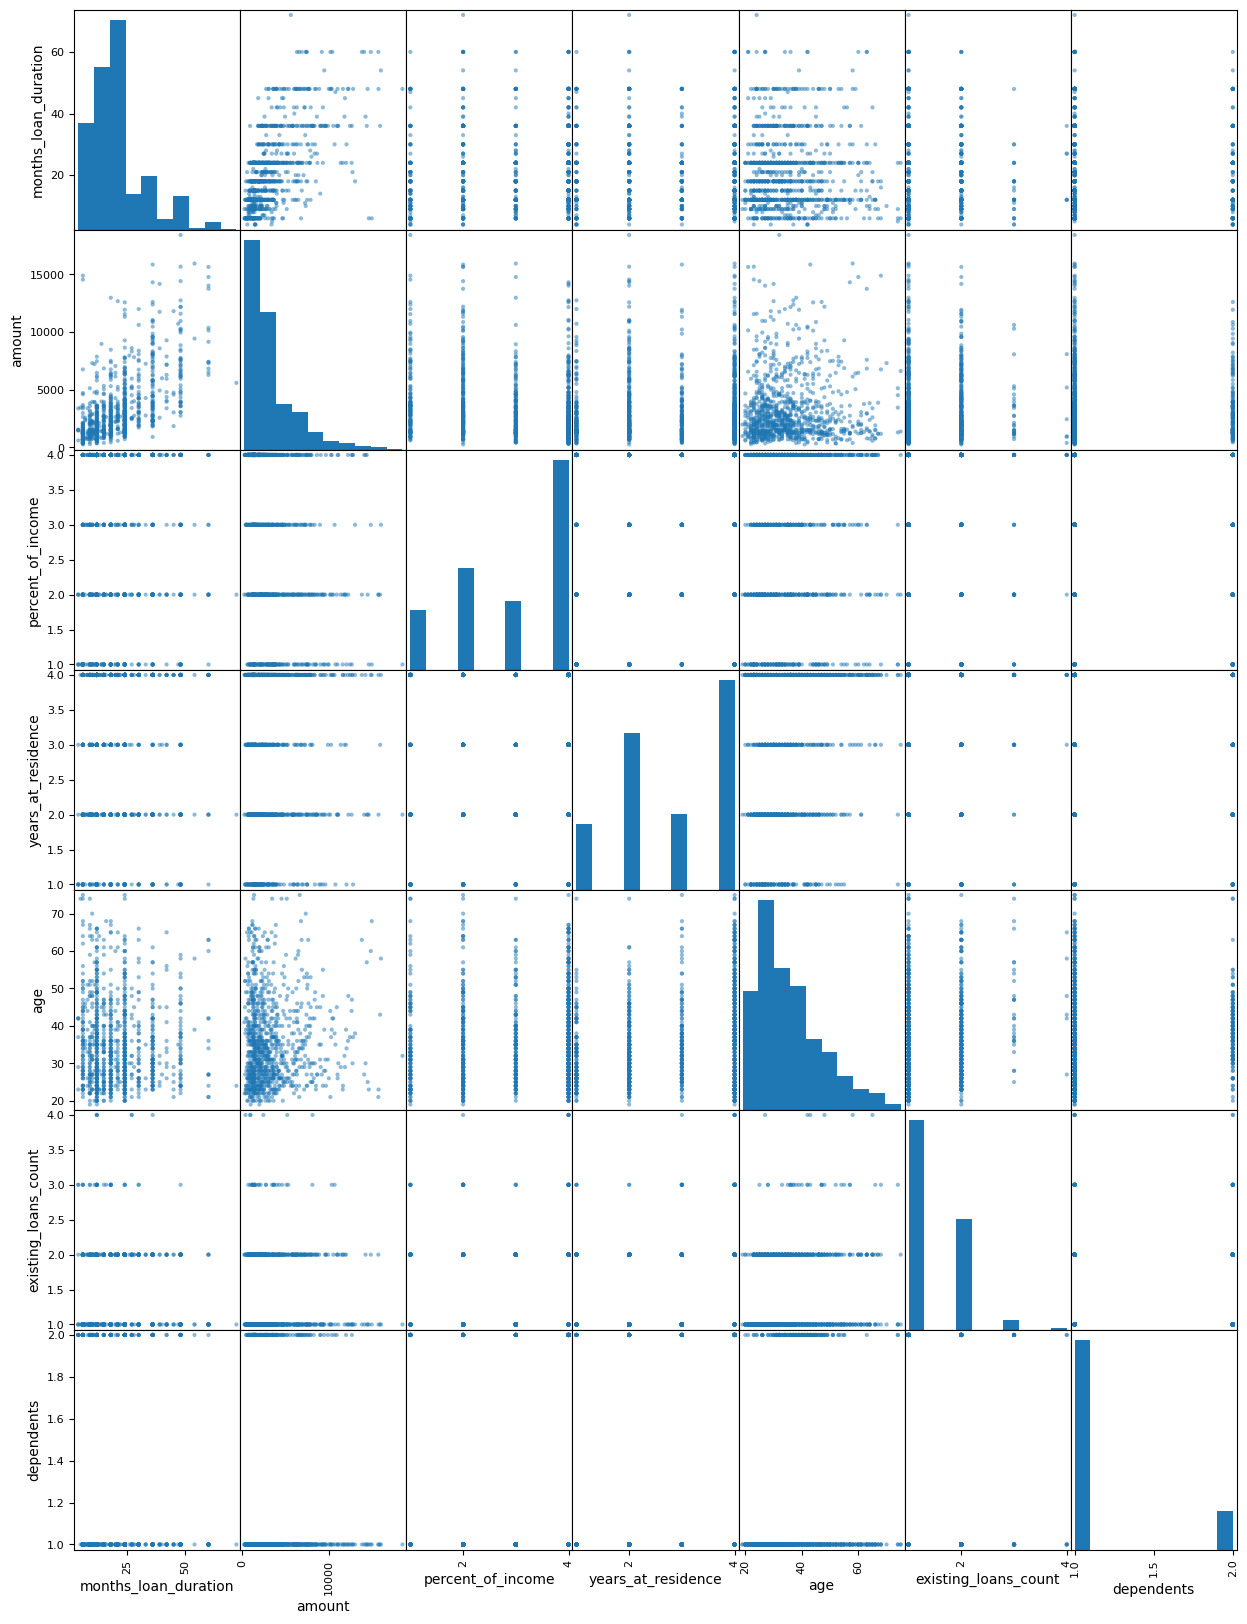

In [5]:
from pandas.plotting import scatter_matrix
#use scatter plot define outliner or center right
scatter_matrix(credit_data, figsize=(15, 20))
plt.show()

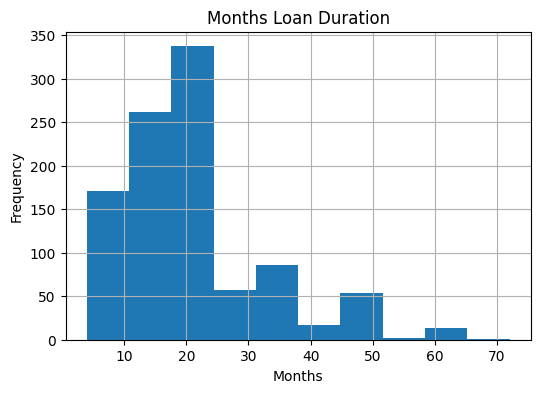

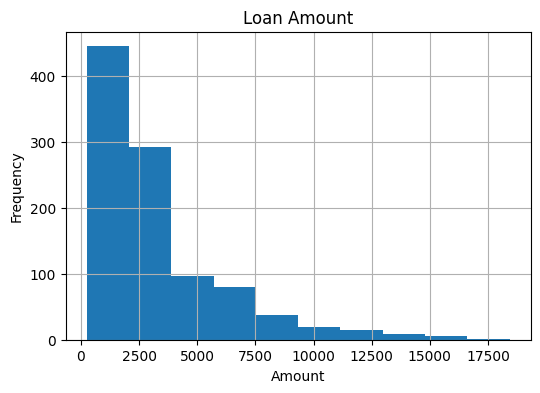

In [6]:
# number feature double check center right data
plt.figure(figsize=(6, 4))
credit_data['months_loan_duration'].hist()
plt.title("Months Loan Duration")
plt.xlabel("Months")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6, 4))
credit_data['amount'].hist()
plt.title("Loan Amount")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

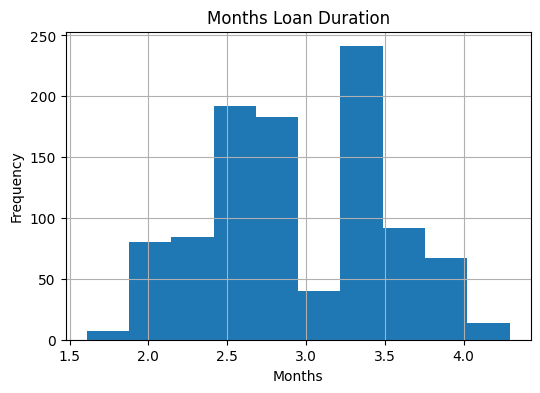

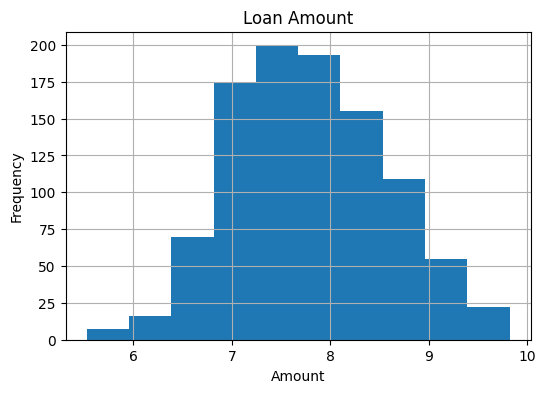

In [7]:
# feature to log
credit_data['months_loan_duration'] = np.log1p(credit_data['months_loan_duration'])
credit_data['amount'] = np.log1p(credit_data['amount'])

plt.figure(figsize=(6, 4))
credit_data['months_loan_duration'].hist()
plt.title("Months Loan Duration")
plt.xlabel("Months")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6, 4))
credit_data['amount'].hist()
plt.title("Loan Amount")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

In [8]:
# set Binary data
credit_data['default'] = credit_data['default'].map({'yes': 1, 'no': 0})
credit_data['phone'] = credit_data['phone'].map({'yes':1, 'no':0})

In [9]:
# Ordinal Encoding
Checking_balance_mapping = {
    'unknown': 0,
    '< 0 DM': 1,
    '1 - 200 DM': 2,
    '> 200 DM': 3
}

credit_data['checking_balance_encoded'] = credit_data['checking_balance'].map(Checking_balance_mapping)

Credit_history_mapping = {
    'poor': 0,
    'critical': 1,
    'good': 2,
    'very good': 3,
    'perfect':4
}
credit_data['credit_history_encoded'] = credit_data['credit_history'].map(Credit_history_mapping)

Saving_balance_mapping = {
    'unknown': 0,
    '< 100 DM': 1,
    '100 - 500 DM': 2,
    '500 - 1000 DM': 3,
    '> 1000 DM': 4
}
credit_data['savings_balance_encoded'] = credit_data['savings_balance'].map(Saving_balance_mapping)

employment_duration_mapping = {
    'unemployed': 0,
    '< 1 year':1,
    '1 - 4 years': 2,
    '4 - 7 years': 3,
    '> 7 years': 4
}
credit_data['employment_duration_encoded'] = credit_data['employment_duration'].map(employment_duration_mapping)


In [10]:
# Creat new feature age_group, debt_income_ratio,credit_unilization
credit_data['age_group'] = credit_data['age'].apply(lambda x: 'young' if x <30 else 'middle' if x <50 else 'senior')

# debt to income ration: monthly payment/ monthly income
credit_data['debt_income_ratio'] = (
    credit_data['amount']/credit_data['months_loan_duration'])/(
        credit_data['amount']/credit_data['percent_of_income'] * 100)

#Credit Utilization, +1 for if saving balance is 0
credit_data['credit_utilization'] = credit_data['amount']/(credit_data['savings_balance_encoded']+1)

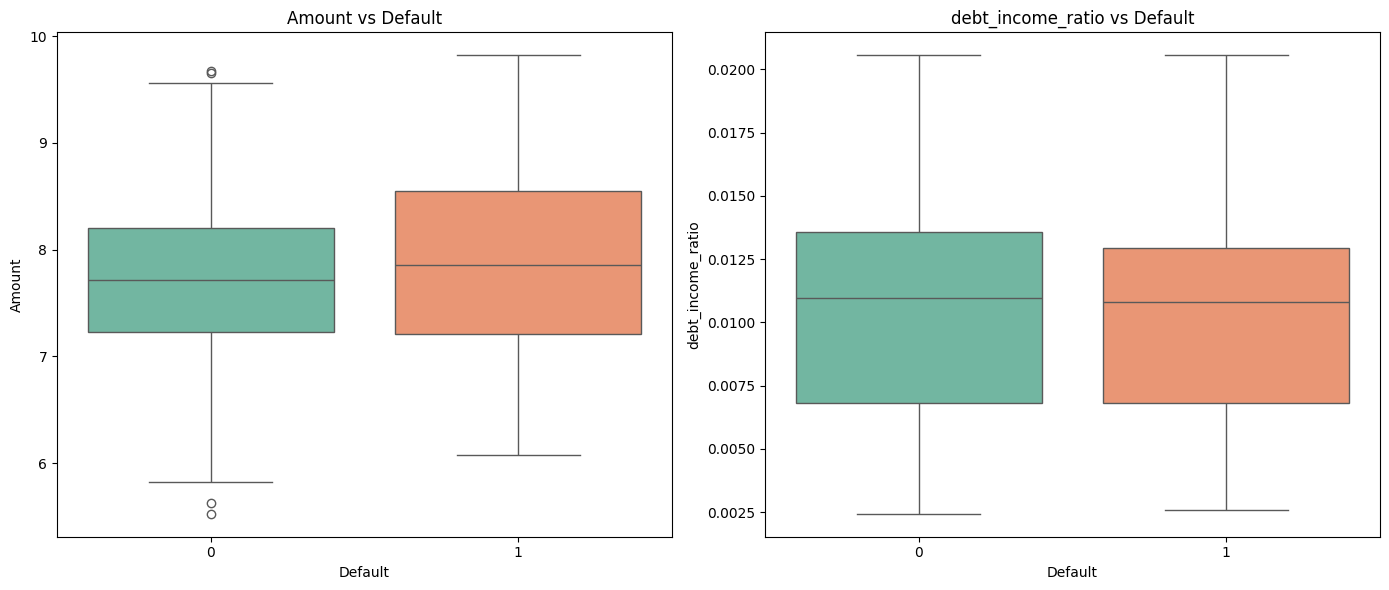

In [11]:
# The relationship between default with amount and debat income ratio

# subboxplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot 1: amount vs default
sns.boxplot(x='default', y='amount', hue='default',
            data=credit_data, palette='Set2', ax=axes[0], legend=False)
axes[0].set_title('Amount vs Default')
axes[0].set_xlabel('Default')
axes[0].set_ylabel('Amount')

# Boxplot 2: debt to income ratio vs default
sns.boxplot(x='default', y='debt_income_ratio', hue='default',
            data=credit_data, palette='Set2', ax=axes[1], legend=False)
axes[1].set_title('debt_income_ratio vs Default')
axes[1].set_xlabel('Default')
axes[1].set_ylabel('debt_income_ratio')

plt.tight_layout()
plt.show()

# Set X and Y values, then split to train and test data

In [12]:
from  sklearn.model_selection import train_test_split

# set X and y
y = credit_data['default']
X = credit_data.drop(columns=['default', 'savings_balance', 'checking_balance', 'employment_duration', 'credit_history'])

# Selecting 80% of the training data randomly
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline

num_feature = [
    'checking_balance_encoded','months_loan_duration', 'credit_history_encoded', 'amount','savings_balance_encoded',
    'employment_duration_encoded', 'percent_of_income', 'years_at_residence', 'age', 'dependents',
    'phone', 'debt_income_ratio', 'credit_utilization','existing_loans_count'
]
cat_feature = [
    'age_group', 'purpose','other_credit','housing','job'
]

# num_pipeline = Pipeline([
#     ('poly', PolynomialFeatures(degree=2, include_bias=False)),
#     ('scaler', StandardScaler())
# ])

preprocessor = ColumnTransformer(transformers = [
     ('num', StandardScaler(), num_feature),
    ('cat',  OneHotEncoder(), cat_feature),
])

x_prepared = preprocessor.fit_transform(x_train)
test_x_prepare = preprocessor.transform(x_test)

# Model 1 Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x_prepared, y_train)

LogisticRegression()

In [15]:
log_reg.coef_, log_reg.intercept_

(array([[ 0.36136373,  0.43602763,  0.29579168,  0.26660973, -0.64830655,
         -0.25528771,  0.37590345, -0.02713794, -0.07825256,  0.13648884,
         -0.06745249, -0.09741551, -0.79595744,  0.01045393, -0.24518191,
          0.20055655,  0.03131965, -0.09193082, -0.01138276, -0.38573776,
          0.48238963, -0.26175299,  0.25510898,  0.24754821, -0.40271971,
          0.14186578,  0.11900941, -0.34777931,  0.21546418,  0.10266554,
          0.06744583, -0.28751586,  0.10409877]]),
 array([-0.42067292]))

In [16]:
Model1_train_pre = log_reg.predict(x_prepared)
Model1_train_conmatrix = confusion_matrix(y_train, Model1_train_pre)
Model1_test_pre = log_reg.predict(test_x_prepare)
Model1_test_conmatrix = confusion_matrix(y_test, Model1_test_pre)

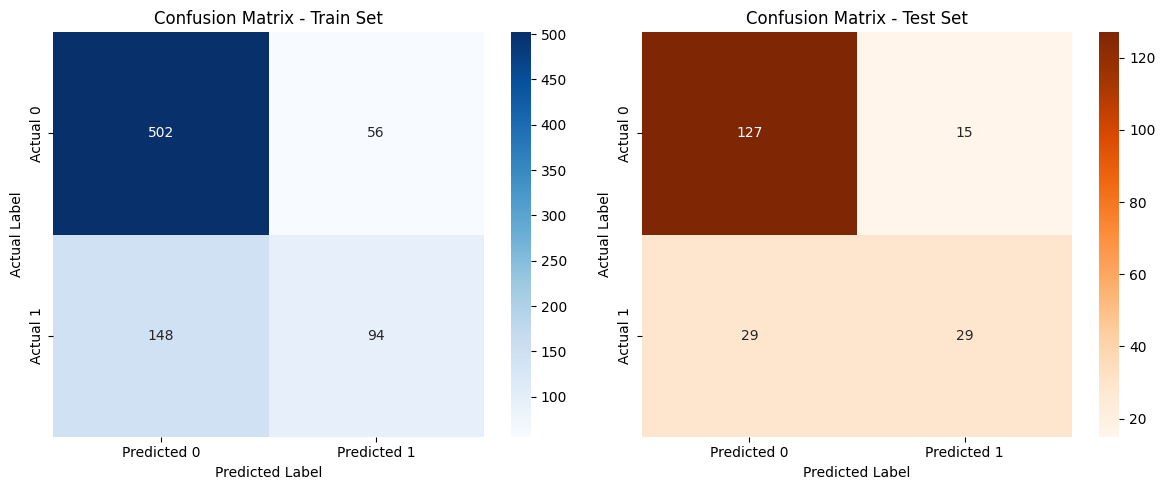

In [17]:
# creat DataFrame 
df_cm_train = pd.DataFrame(Model1_train_conmatrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
df_cm_test = pd.DataFrame(Model1_test_conmatrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


sns.heatmap(df_cm_train, annot=True, cmap="Blues", fmt="d", ax=axes[0])
axes[0].set_title("Confusion Matrix - Train Set")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("Actual Label")

sns.heatmap(df_cm_test, annot=True, cmap="Oranges", fmt="d", ax=axes[1])
axes[1].set_title("Confusion Matrix - Test Set")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("Actual Label")

plt.tight_layout()
plt.show()

# Model 2 Logistic regression model with regularization (C parameter)
## Try to reduce false negative and improve recall, since don't want default label as nondefault

In [18]:
log_reg_c = LogisticRegression(class_weight='balanced', C=0.01, max_iter=10000)
log_reg_c.fit(x_prepared, y_train)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=10000)

In [19]:
from sklearn.model_selection import GridSearchCV

# params = {"C": np.logspace(-3, 1, 10)}  # 0.001 ~ 10
params = {"C": np.linspace(0.01, 2, 10)}

# put cv as integer no shuffle
grid_logregC = GridSearchCV(log_reg_c, params, cv =5, scoring= 'recall')

grid_logregC.fit(x_prepared, y_train)

best_C = grid_logregC.best_params_['C']
best_logregC = grid_logregC.best_estimator_
model2_recall = grid_logregC.best_score_

print(f"Best C : {best_C:.5f}")
print(f"Recall: {model2_recall:.5f}")


Best C : 0.01000
Recall: 0.64014


In [20]:
Model2_train_pre = best_logregC.predict(x_prepared)
Model2_train_conmatrix = confusion_matrix(y_train, Model2_train_pre)
Model2_test_pre = best_logregC.predict(test_x_prepare)
Model2_test_conmatrix = confusion_matrix(y_test, Model2_test_pre)

In [21]:
Model1_test_conmatrix, Model2_test_conmatrix

(array([[127,  15],
        [ 29,  29]]),
 array([[91, 51],
        [19, 39]]))

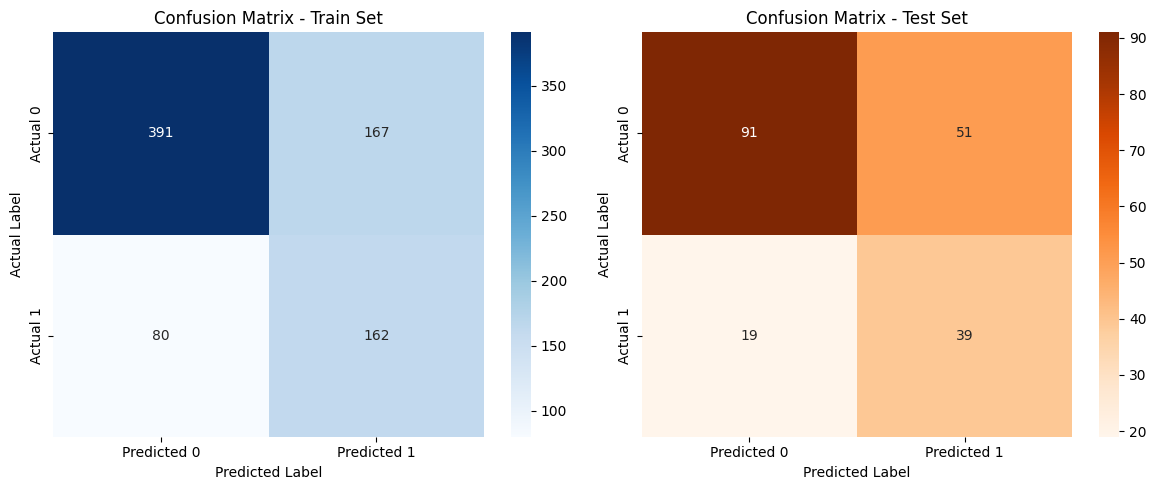

In [22]:
# creat DataFrame 
df_cm_train2 = pd.DataFrame(Model2_train_conmatrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
df_cm_test2 = pd.DataFrame(Model2_test_conmatrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


sns.heatmap(df_cm_train2, annot=True, cmap="Blues", fmt="d", ax=axes[0])
axes[0].set_title("Confusion Matrix - Train Set")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("Actual Label")

sns.heatmap(df_cm_test2, annot=True, cmap="Oranges", fmt="d", ax=axes[1])
axes[1].set_title("Confusion Matrix - Test Set")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("Actual Label")

plt.tight_layout()
plt.show()

# Model 3 Logistic regression with L1 L2 ElasticNet

In [32]:

params_model3 = {
    'l1_ratio': np.linspace(0.01, 1, 30),
    'C': np.linspace(0.01, 0.99, 10)
}

log_reg_model3 = LogisticRegression(
    penalty='elasticnet', solver='saga', class_weight='balanced', max_iter=10000
)
grid_model3 = GridSearchCV(log_reg_model3, params_model3,scoring='recall', cv=5)

grid_model3.fit(x_prepared, y_train)

best_C_model3 = grid_model3.best_params_['C']
best_l1_ratio = grid_model3.best_params_['l1_ratio']

best_model3 = grid_model3.best_estimator_
model3_recall = grid_model3.best_score_

print(f"Best C : {best_C_model3:.5f}")
print(f"Recall: {model3_recall:.5f}")

Model3_train_pre = best_model3.predict(x_prepared)
Model3_train_conmatrix = confusion_matrix(y_train, Model3_train_pre)
Model3_test_pre = best_model3.predict(test_x_prepare)
Model3_test_conmatrix = confusion_matrix(y_test, Model3_test_pre)

Best C : 0.01000
Recall: 0.80000


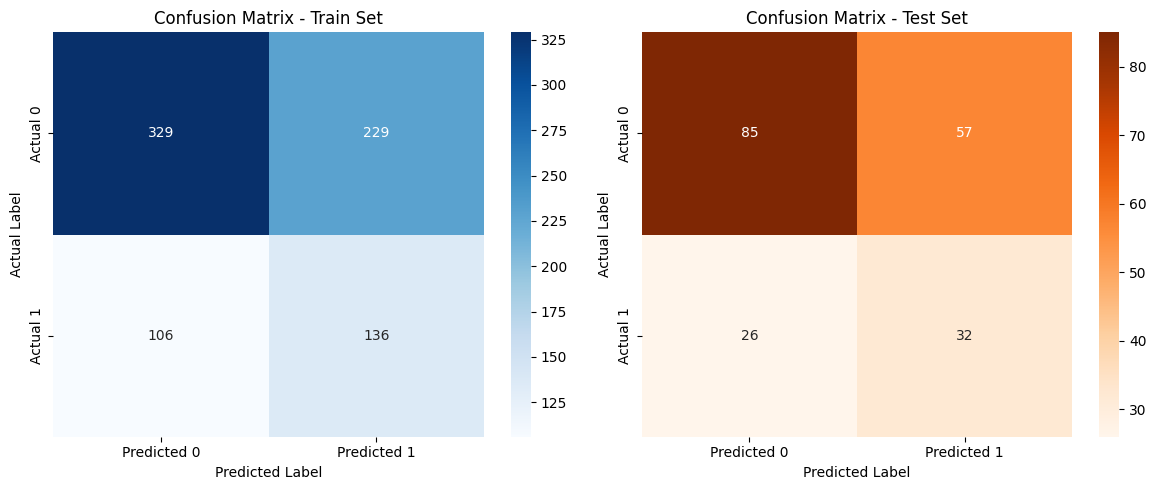

In [33]:
# creat DataFrame 
df_cm_train3 = pd.DataFrame(Model3_train_conmatrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
df_cm_test3 = pd.DataFrame(Model3_test_conmatrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


sns.heatmap(df_cm_train3, annot=True, cmap="Blues", fmt="d", ax=axes[0])
axes[0].set_title("Confusion Matrix - Train Set")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("Actual Label")

sns.heatmap(df_cm_test3, annot=True, cmap="Oranges", fmt="d", ax=axes[1])
axes[1].set_title("Confusion Matrix - Test Set")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("Actual Label")

plt.tight_layout()
plt.show()

# Model 4 SVM kernel

In [25]:
from sklearn.svm import SVC

svm_clf = SVC(kernel="rbf", class_weight='balanced')
svm_clf.fit(x_prepared, y_train)

params1 = {
    'gamma': np.linspace(0.01, 1, 30),
    'C': np.linspace(0.01, 0.99, 10)
}

grid_search_model4 = GridSearchCV(svm_clf, params1, cv=5, scoring="recall")
grid_search_model4.fit(x_prepared, y_train)

print("Best Parameters:", grid_search_model4.best_params_)
print("Best Score:", grid_search_model4.best_score_)

best_model4 = grid_search_model4.best_estimator_
# Model4_test_pre = best_model4.predict(x_prepared)

Best Parameters: {'C': np.float64(0.11888888888888888), 'gamma': np.float64(0.01)}
Best Score: 0.6693027210884354


In [26]:
Model4_test_pre = best_model4.predict(test_x_prepare)
Model4_test_conmatrix = confusion_matrix(y_test, Model4_test_pre)

In [27]:
Model4_test_conmatrix

array([[88, 54],
       [15, 43]])

In [28]:
Model4_train_pre = best_model4.predict(x_prepared)
Model4_train_conmatrix = confusion_matrix(y_train, Model4_train_pre)

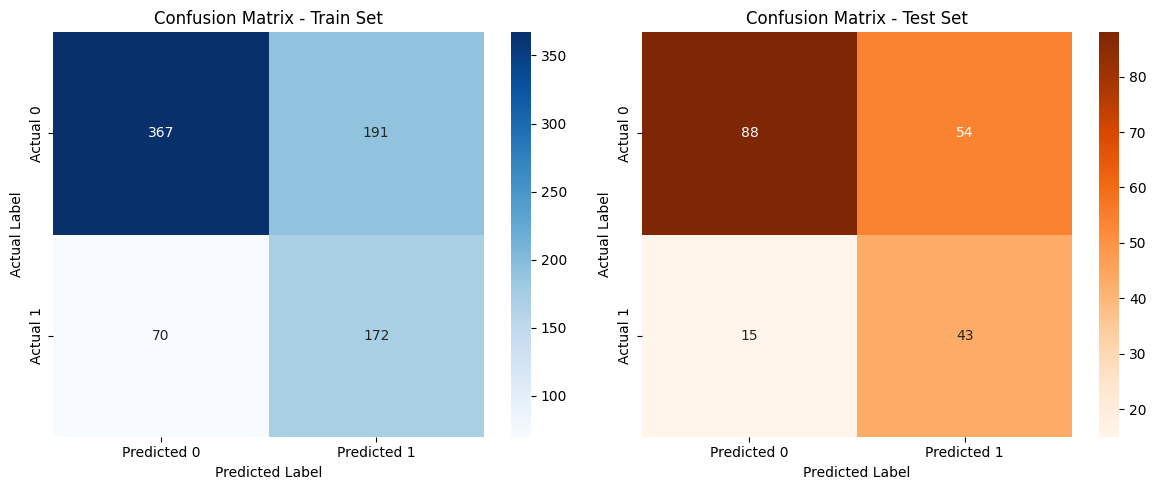

In [29]:
# creat DataFrame 
df_cm_train4 = pd.DataFrame(Model4_train_conmatrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
df_cm_test4 = pd.DataFrame(Model4_test_conmatrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


sns.heatmap(df_cm_train4, annot=True, cmap="Blues", fmt="d", ax=axes[0])
axes[0].set_title("Confusion Matrix - Train Set")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("Actual Label")

sns.heatmap(df_cm_test4, annot=True, cmap="Oranges", fmt="d", ax=axes[1])
axes[1].set_title("Confusion Matrix - Test Set")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("Actual Label")

plt.tight_layout()
plt.show()

# Model comparation 

In [35]:
from sklearn.metrics import classification_report
report_model1 = classification_report(y_test, Model1_test_pre, output_dict=True)
report_model2 = classification_report(y_test, Model2_test_pre, output_dict=True)
report_model3 = classification_report(y_test, Model3_test_pre, output_dict=True)
report_model4 = classification_report(y_test, Model4_test_pre, output_dict=True)


# -------- compare report --------
compare_df = pd.DataFrame({
    'Model 1': {
        'Recall': report_model1['1']['recall'],
        'Precision': report_model1['1']['precision'],
        'F1-score': report_model1['1']['f1-score'],
        'False Negatives': Model1_test_conmatrix[1, 0],
        'True Positives': Model1_test_conmatrix[1, 1]
    },
    'Model 2': {
        'Recall': report_model2['1']['recall'],
        'Precision': report_model2['1']['precision'],
        'F1-score': report_model2['1']['f1-score'],
        'False Negatives': Model2_test_conmatrix[1, 0],
        'True Positives': Model2_test_conmatrix[1, 1]
    },
    'Model 3': {
        'Recall': report_model3['1']['recall'],
        'Precision': report_model3['1']['precision'],
        'F1-score': report_model3['1']['f1-score'],
        'False Negatives': Model3_test_conmatrix[1, 0],
        'True Positives': Model3_test_conmatrix[1, 1]
    },
    'Model 4': {
        'Recall': report_model4['1']['recall'],
        'Precision': report_model4['1']['precision'],
        'F1-score': report_model4['1']['f1-score'],
        'False Negatives': Model4_test_conmatrix[1, 0],
        'True Positives': Model4_test_conmatrix[1, 1]
    }
})
print("Model compare：\n")
print(compare_df)

Model compare：

                   Model 1    Model 2    Model 3    Model 4
Recall            0.500000   0.672414   0.551724   0.741379
Precision         0.659091   0.433333   0.359551   0.443299
F1-score          0.568627   0.527027   0.435374   0.554839
False Negatives  29.000000  19.000000  26.000000  15.000000
True Positives   29.000000  39.000000  32.000000  43.000000


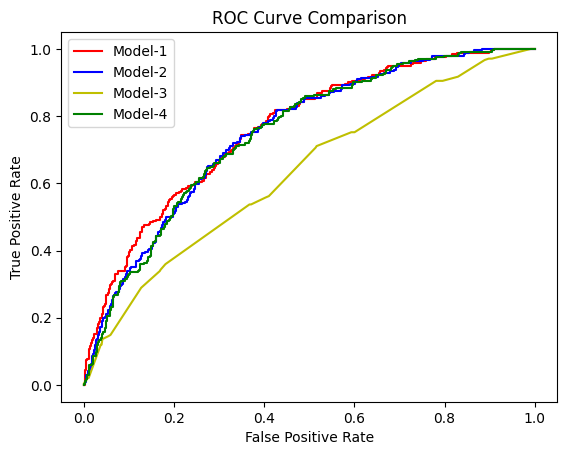

In [37]:
from sklearn.metrics import roc_curve

# model 1
decision_func_train_lr = log_reg.decision_function(x_prepared)
fpr, tpr, thresholds = roc_curve(y_train, decision_func_train_lr)

# model 2
decision_func_train_lrc = best_logregC.decision_function(x_prepared)
fpr2, tpr2, thresholds2 = roc_curve(y_train, decision_func_train_lrc)

# model 3
decision_func_train_l1 = best_model3.decision_function(x_prepared)
fpr3, tpr3, thresholds3 = roc_curve(y_train, decision_func_train_l1)

# model 3
decision_func_train_svm = best_model4.decision_function(x_prepared)
fpr4, tpr4, thresholds4 = roc_curve(y_train, decision_func_train_svm)

plt.plot(fpr, tpr, 'r-', label = 'Model-1')
plt.plot(fpr2,tpr2, 'b-', label = 'Model-2')
plt.plot(fpr3,tpr3, 'y-', label = 'Model-3')
plt.plot(fpr4,tpr4, 'g-', label = 'Model-4')


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()